## Preprosessing

### Create File CSV

In [88]:
import os
import re
import pickle
import numpy as np
import pandas as pd

from textblob import Word
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

In [2]:
data_folder = "Dataset/txt"
folders = ["campuran","maju","mundur"]

os.chdir(data_folder)
print(os.getcwd())

x = []
y = []

/home/antoko/Documents/KULIAH/Semester 6/Kuliah/Penggalian Data/Tugas/Tubes/Coding/Cerpen/Dataset/txt


In [3]:
for i in folders:
    files = os.listdir(i)
    print(i)
    for text_file in files:
        file_path = i + "/" +text_file
        #         print("reading file:", file_path)
        with open(file_path, encoding='mac_roman') as f:
            data = f.readlines()
        data = ' '.join(data)
        x.append(data)
        y.append(i)

campuran
maju
mundur


In [4]:
data = {'news': x, 'type': y}       
df = pd.DataFrame(data)
df.head()

,news,type
0,Memang tidak ada yang terbiasa dengan kehilang...,campuran
1,Berawal dari sebuah perusahaan swasta dimana t...,campuran
2,"Tepat pada malam Jumat, 27 Oktober 2017 kedua ...",campuran
3,"Sore hari itu, Reza sedang bekerja. Dia adalah...",campuran
4,Tasynia adalah anak yang malas dan enggan mela...,campuran


In [5]:
os.chdir('../../')
print(os.getcwd())
df.to_csv('dataset.csv', index=False)
print('writing csv flie ...')

/home/antoko/Documents/KULIAH/Semester 6/Kuliah/Penggalian Data/Tugas/Tubes/Coding/Cerpen
writing csv flie ...


### Cleaning Data

In [90]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [91]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
data = pd.read_csv('dataset.csv')
# data['type'] = lb_make.fit_transform(data['type'])
x = data['news'].tolist()
y = data['type'].tolist()

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()
# stemmer.stem(x[0])

In [92]:
for index,value in enumerate(x):
#     x[index] = stemmer.stem(value)
#     x[index] = ' '.join(stemmer.stem(value).split())
#     print("processing data:",index)
    x[index] = ' '.join([Word(word).lemmatize() for word in clean_str(value).split()])
# x

In [93]:
VSM = CountVectorizer().fit_transform(x)
X = TfidfTransformer().fit_transform(VSM)
Y = np.array(y)
# vect = TfidfVectorizer(stop_words='english',min_df=2)
# X = vect.fit_transform(x)
# Y = np.array(y)

In [102]:
print("no of features extracted:",X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print("train size:", X_train.shape)
print("test size:", X_test.shape)

no of features extracted: 16834
train size: (195, 16834)
test size: (66, 16834)


### Create Model

#### Random Forest (Gak digunakan dalam paper ini, hanya percobaan)

In [103]:
model = RandomForestClassifier(n_estimators=300, max_depth=150,n_jobs=2)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=150, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [104]:
y_pred = model.predict(X_test)
# y_pred = clf.predict(X_test.toarray())
c_mat = confusion_matrix(y_test,y_pred)
kappa = cohen_kappa_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
print("Confusion Matrix:\n", c_mat)
print("\nKappa: ",kappa)
print("\nAccuracy: ",acc)

Confusion Matrix:
 [[ 0 15  0]
 [ 0 42  0]
 [ 0  9  0]]

Kappa:  0.0

Accuracy:  0.6363636363636364


### Naive Bayes

In [105]:
clf = GaussianNB()
clf.fit(X_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [106]:
# y_pred = model.predict(X_test)
y_pred = clf.predict(X_test.toarray())
c_mat = confusion_matrix(y_test,y_pred)
# kappa = cohen_kappa_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
print("Confusion Matrix:\n", c_mat)
# print("\nKappa: ",kappa)
print("\nAccuracy: ",acc)

Confusion Matrix:
 [[ 0 13  2]
 [ 7 31  4]
 [ 0  7  2]]

Accuracy:  0.5


### KNN

In [107]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn= KNeighborsClassifier(n_neighbors=10)
score= cross_val_score(knn, X, Y, cv=10, scoring='accuracy') 
print(score)
print(score.mean())

[0.51851852 0.62962963 0.55555556 0.51851852 0.48148148 0.55555556
 0.61538462 0.6        0.45833333 0.625     ]
0.5557977207977208


In [108]:
k_range = range(1,31)  #1-30
k_score = []
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    score= cross_val_score(knn, X, Y, cv=10, scoring='accuracy')
    k_score.append(score.mean())
print(k_score)

[0.46960541310541315, 0.459005698005698, 0.4892279202279203, 0.4963148148148148, 0.5033774928774928, 0.5003162393162394, 0.5231552706552706, 0.5317849002849002, 0.5552165242165242, 0.5557977207977208, 0.5633717948717949, 0.5684643874643875, 0.5718589743589744, 0.568025641025641, 0.5873034188034187, 0.5873034188034187, 0.5910071225071225, 0.5868404558404559, 0.5950071225071225, 0.5908404558404559, 0.5871367521367521, 0.5945441595441595, 0.5908404558404559, 0.5908404558404559, 0.5945441595441595, 0.5945441595441595, 0.5945441595441595, 0.5945441595441595, 0.5945441595441595, 0.5945441595441595]


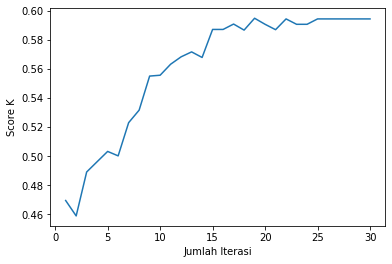

In [109]:
import matplotlib.pyplot as plt
plt.plot(k_range, k_score)
plt.xlabel('Jumlah Iterasi')
plt.ylabel('Score K')
plt.show()

In [16]:
model_path = "model.pickle"
vectorizer_path = "vectorizer.pickle"
pickle.dump(model, open(model_path, 'wb'))
pickle.dump(vect, open(vectorizer_path, "wb"))